# BCG Argo data
Code comes from BGC-Argo Workshop: https://github.com/Flavi1P/apart_demo

In [32]:
# Loading libraries
import argopy as ar
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

Downloaded data from argo located within near the southern Icelandic shelf

In [33]:
ds = ar.DataFetcher(src="gdac").float(7902223).to_xarray()
with ar.set_options(mode='expert'):
    ds_bgc = ar.DataFetcher(backend='erddap', ds = 'bgc').float(7902223).to_xarray()
prof = ar.ArgoFloat(7902223).open_dataset('prof')

In [34]:
display(ds)
display(ds_bgc)

<xarray.Dataset> Size: 1MB
Dimensions:          (N_POINTS: 9985)
Coordinates:
    TIME             (N_POINTS) datetime64[ns] 80kB 2024-09-02T20:07:37 ... 2...
    LATITUDE         (N_POINTS) float64 80kB 62.37 62.37 62.37 ... 62.73 62.73
    LONGITUDE        (N_POINTS) float64 80kB -18.76 -18.76 ... -30.04 -30.04
  * N_POINTS         (N_POINTS) int64 80kB 0 1 2 3 4 ... 9981 9982 9983 9984
Data variables: (12/15)
    CYCLE_NUMBER     (N_POINTS) int64 80kB 1 1 1 1 1 1 1 ... 47 47 47 47 47 47
    DATA_MODE        (N_POINTS) <U1 40kB 'R' 'R' 'R' 'R' 'R' ... 'R' 'R' 'R' 'R'
    DIRECTION        (N_POINTS) <U1 40kB 'A' 'A' 'A' 'A' 'A' ... 'A' 'A' 'A' 'A'
    PLATFORM_NUMBER  (N_POINTS) int64 80kB 7902223 7902223 ... 7902223 7902223
    POSITION_QC      (N_POINTS) int64 80kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    PRES             (N_POINTS) float32 40kB 3.5 4.6 5.6 ... 1.125e+03 1.157e+03
    ...               ...
    PSAL_ERROR       (N_POINTS) float32 40kB nan nan nan nan ... nan nan nan nan
    PSAL_QC          (N_POINTS) int64 80kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TEMP             (N_POINTS) float32 40kB 11.52 11.52 11.52 ... 3.895 3.788
    TEMP_ERROR       (N_POINTS) float32 40kB nan nan nan nan ... nan nan nan nan
    TEMP_QC          (N_POINTS) int64 80kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
    TIME_QC          (N_POINTS) int64 80kB 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1
Attributes:
    DATA_ID:              ARGO
    DOI:                  http://doi.org/10.17882/42182
    Fetched_by:           davidlewis
    Fetched_constraints:  WMO7902223
    Fetched_date:         2025/09/12
    Fetched_from:         https://data-argo.ifremer.fr
    Fetched_uri:          https://data-argo.ifremer.fr/dac/coriolis/7902223/7...
    Processing_history:   Transformed with 'profile2point'; URI merged with '...
    raw_attrs:            {'title': 'Argo float vertical profile', 'instituti...

<xarray.Dataset> Size: 21MB
Dimensions:                            (N_POINTS: 43095)
Coordinates:
    LATITUDE                           (N_POINTS) float64 345kB ...
    LONGITUDE                          (N_POINTS) float64 345kB ...
    TIME                               (N_POINTS) datetime64[ns] 345kB ...
  * N_POINTS                           (N_POINTS) int64 345kB 0 1 ... 43094
Data variables: (12/84)
    BBP700                             (N_POINTS) float32 172kB ...
    BBP700_ADJUSTED                    (N_POINTS) float32 172kB ...
    BBP700_ADJUSTED_ERROR              (N_POINTS) float32 172kB ...
    BBP700_ADJUSTED_QC                 (N_POINTS) int64 345kB 0 0 0 3 ... 1 0 1
    BBP700_DATA_MODE                   (N_POINTS) <U1 172kB 'A' 'A' ... 'A' 'A'
    BBP700_QC                          (N_POINTS) int64 345kB 0 0 0 3 ... 1 0 1
    ...                                 ...
    TEMP_ADJUSTED                      (N_POINTS) float32 172kB ...
    TEMP_ADJUSTED_ERROR                (N_POINTS) float32 172kB ...
    TEMP_ADJUSTED_QC                   (N_POINTS) int64 345kB 8 8 8 8 ... 8 1 8
    TEMP_DATA_MODE                     (N_POINTS) <U1 172kB 'R' 'R' ... 'R' 'R'
    TEMP_QC                            (N_POINTS) int64 345kB 3 3 3 3 ... 8 1 8
    TIME_QC                            (N_POINTS) int64 345kB 1 1 1 1 ... 1 1 1
Attributes:
    DATA_ID:              ARGO-BGC
    DOI:                  http://doi.org/10.17882/42182
    Fetched_from:         erddap.ifremer.fr
    Fetched_by:           davidlewis
    Fetched_date:         2025/09/12
    Fetched_constraints:  WMO7902223
    Fetched_uri:          https://erddap.ifremer.fr/erddap/tabledap/ArgoFloat...

## Float Trajectory

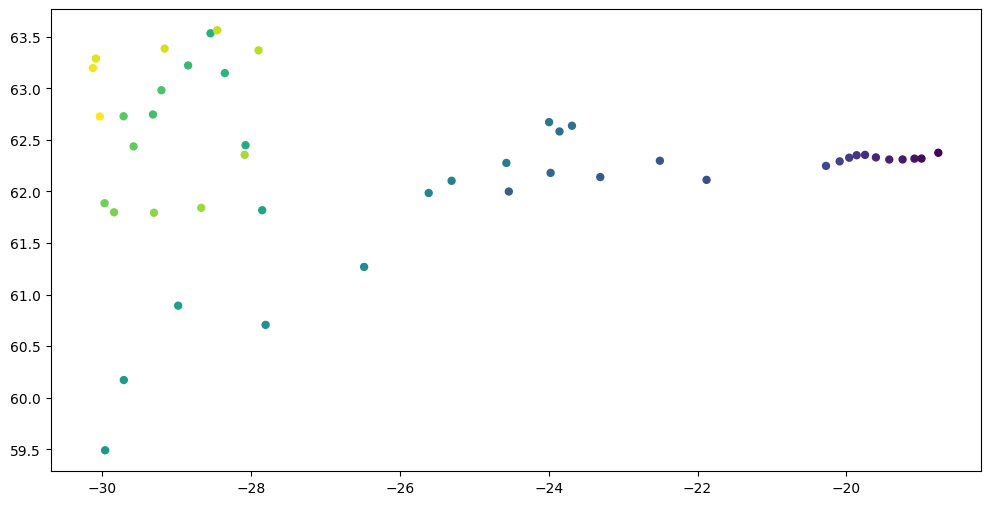

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.scatter(prof['LONGITUDE'].values, prof['LATITUDE'].values,c = prof['CYCLE_NUMBER'], s=25)
plt.show()

In [48]:
def plot_transect(ds, varname = 'CHLA_ADJUSTED', depth_min = 0, depth_max = 100, log_scale=False):
    # Build dataset from point-form arrays
    ds_points = xr.Dataset(
        {
            "VAR": ("obs", ds[varname].values),
            "PRES": ("obs", ds['PRES'].values),
            "TIME": ("obs", ds['TIME'].values)
        }
    )

    # Unique profile times
    times_unique = np.unique(ds_points['TIME'].values)

    # Regular pressure grid
    depth_grid = np.arange(depth_min, depth_max, 2)  # adjust range and step as needed

    profiles = []
    for t in times_unique:
        # Select all measurements at this time
        mask_time = ds_points['TIME'].values == t
        pres_vals = ds_points['PRES'].values[mask_time]
        var_vals = ds_points['VAR'].values[mask_time]
        
        # Drop NaNs before interpolation
        mask_valid = np.isfinite(pres_vals) & np.isfinite(var_vals)
        if mask_valid.sum() > 1:
            var_interp = np.interp(depth_grid, pres_vals[mask_valid], var_vals[mask_valid],
                                    left=np.nan, right=np.nan)
        else:
            var_interp = np.full_like(depth_grid, np.nan, dtype=float)
        profiles.append(var_interp)

    # Convert to xarray DataArray for plotting
    var_section = xr.DataArray(
        np.array(profiles),
        coords={"TIME": times_unique, "PRES": depth_grid},
        dims=("TIME", "PRES")
    )
    units = ds[varname].attrs['units']

    # Plot section
    plt.figure(figsize=(12, 6))
    if log_scale:
        pcm = plt.pcolormesh(
        var_section['TIME'],
        var_section['PRES'],
        var_section.T,
        shading='auto',
        cmap='viridis',
        norm=LogNorm(vmin=1e-3, vmax=np.nanmax(var_section))  # adjust vmin as needed
    )
    else:
        pcm = plt.pcolormesh(var_section['TIME'], var_section['PRES'], var_section.T,
                            shading='auto', cmap='viridis')
    plt.gca().invert_yaxis()
    plt.colorbar(pcm, label=f'{varname} {units}')
    plt.xlabel('Time')
    plt.ylabel('Pressure (dbar)')
    plt.title(f'BGC-Argo {varname} Section (Depth vs Time)')
    plt.tight_layout()
    plt.show()

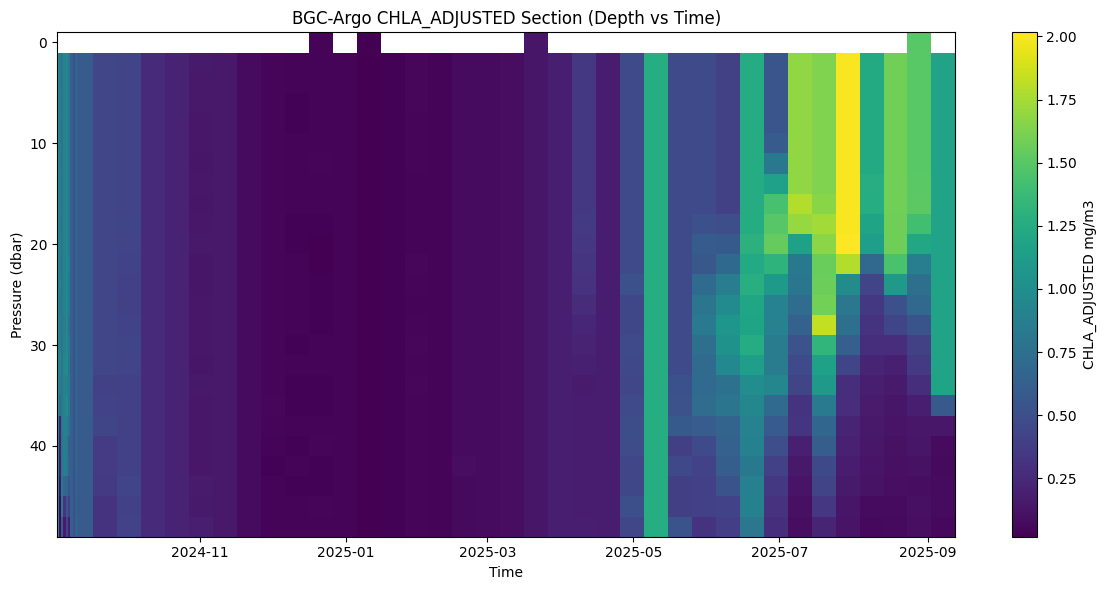

In [49]:
plot_transect(ds_bgc, 'CHLA_ADJUSTED', depth_max = 50, log_scale=False)

In [45]:

def plot_interpolated_section(ds_bgc, varname='CHLA_ADJUSTED', depth_min=0, depth_max=200, log_scale=True):
    # Build dataset from point-form arrays
    ds_points = xr.Dataset(
        {
            "VAR": ("obs", ds_bgc[varname].values),
            "PRES": ("obs", ds_bgc['PRES'].values),
            "TIME": ("obs", ds_bgc['TIME'].values)
        }
    )

    # Unique profile times
    times_unique = np.unique(ds_points['TIME'].values)

    # Regular pressure grid
    depth_grid = np.arange(depth_min, depth_max + 1, 1)  # include depth_max

    profiles = []
    for t in times_unique:
        mask_time = ds_points['TIME'].values == t
        pres_vals = ds_points['PRES'].values[mask_time]
        var_vals = ds_points['VAR'].values[mask_time]

        # Valid mask
        mask_valid = np.isfinite(pres_vals) & np.isfinite(var_vals)
        if mask_valid.sum() > 1:
            var_interp = np.interp(depth_grid, pres_vals[mask_valid], var_vals[mask_valid],
                                   left=np.nan, right=np.nan)
        else:
            var_interp = np.full_like(depth_grid, np.nan, dtype=float)
        profiles.append(var_interp)

    # Create DataArray for gridded section
    var_section = xr.DataArray(
        np.array(profiles),
        coords={"TIME": times_unique, "PRES": depth_grid},
        dims=("TIME", "PRES")
    )

    # Interpolate in time for smoothness
    time_fine = np.linspace(
        np.min(times_unique.astype("datetime64[s]").astype(float)),
        np.max(times_unique.astype("datetime64[s]").astype(float)),
        500
    ).astype("datetime64[s]")

    var_section_smooth = var_section.interp(TIME=time_fine)

    # Plotting
    plt.figure(figsize=(14, 6))

    if log_scale:
        vmin = np.nanmax([1e-6, np.nanmin(var_section_smooth.values[var_section_smooth.values > 0])])
        vmax = np.nanmax(var_section_smooth.values)
        norm = LogNorm(vmin=vmin, vmax=vmax)
        pcm = plt.pcolormesh(
            var_section_smooth['TIME'],
            var_section_smooth['PRES'],
            var_section_smooth.T,
            shading='auto',
            cmap='viridis',
            norm=norm
        )
        cbar = plt.colorbar(pcm, label=f'{varname} (log scale)')
        cbar.ax.yaxis.set_major_locator(LogLocator(base=10, subs=(1, 2, 5)))
    else:
        pcm = plt.pcolormesh(
            var_section_smooth['TIME'],
            var_section_smooth['PRES'],
            var_section_smooth.T,
            shading='auto',
            cmap='viridis'
        )
        plt.colorbar(pcm, label=varname)

    plt.gca().invert_yaxis()
    plt.xlabel('Time')
    plt.ylabel('Pressure (dbar)')
    plt.title(f'Interpolated BGC-Argo {varname} Section (Depth vs Time)')
    plt.tight_layout()
    plt.show()


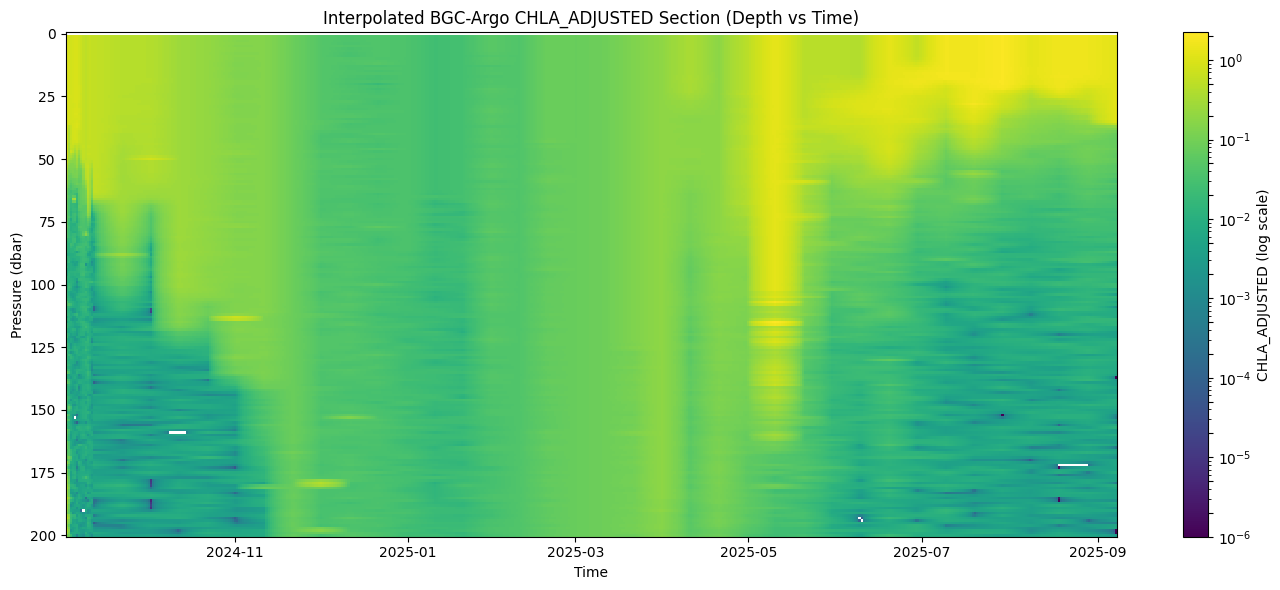

In [46]:
plot_interpolated_section(ds_bgc, 'CHLA_ADJUSTED', depth_max=200, log_scale=True)